# Simulation of an Metal Oxide Semiconductor Diode


The following code loads the needed modules.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from synumses.one_dimension.scharfetter_gummel_bernoulli import bernoulli, jacobian, update_b, first_jacobian, first_update_b, hole_current_density, electron_current_density

import synumses.one_dimension.parameters as parameters

from synumses.one_dimension.functions import  ohm_potential, calc_p_density, calc_n_density, calc_recombination


import synumses.one_dimension.solver as solver

# The limit for approximating the Bernoulli function by a polynome is increased!
#parameters.bernoulli_limit = 5E0

## Definition of the geometry of the MOS diode
The band gap of $\mathrm{SiO_x}$ is set to $E_\mathrm{g} = 5.3\,\mathrm{eV}$.<br>
The doping level of the silicon is set to $N_\mathrm{a}=1 \cdot 10^{14}\,\mathrm{cm^3}$.

In [29]:
parameters.n = 100 #300
parameters.lx = 400E-9 #2400E-9

parameters.init_geometry()

parameters.init_parameters()

#parameters.Cau = 0*1E-24  

Nd_Met   = 1.0E23
Nd_Si    = 1.0E25

Er_Met = 1E1
Er_Si = 11.6

Chi_Si  = 4.05
Eg_Si   = 1.12

Chi_Met = 4.05 + 0.5
Eg_Met  = 0.01

# Transition Metal to Si
x1 = 100E-9

for i in range(0, parameters.n):
    
    if parameters.pos_x[i] < x1:
        parameters.Chi[i] = Chi_Met
        parameters.Eg[i]  = Eg_Met
        
        parameters.Epsilon[i] =  parameters.Epsilon_0 * Er_Met    
        
        parameters.C[i] = + Nd_Met
        
    else:
        parameters.Chi[i] = Chi_Si
        parameters.Eg[i]  = Eg_Si
        
        parameters.Epsilon[i] =  parameters.Epsilon_0 * Er_Si
        
        parameters.C[i] = Nd_Si
   

## Plot Metal Semiconductor structure

Now, we plot the default band diagram and the doping levels

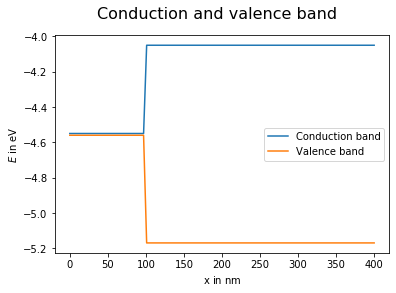

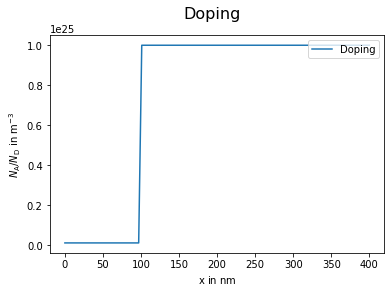

In [30]:
# Band diagram
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Conduction and valence band", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.Chi, label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.Chi-parameters.Eg, label='Valence band')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$E$ in $\mathrm{eV}$")

axis.legend()
plt.show()

# Doping level
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Doping", fontsize=16)

#axis.semilogy(np.abs(parameters.C), label='Doping')
axis.plot(parameters.pos_x * 1E9, np.abs(parameters.C), label='Doping')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$N_\mathrm{A} / N_\mathrm{D}$ in $\mathrm{m^{-3}}$")

axis.legend(loc='upper right')
plt.show()


## Simulaiton without biasing

In [31]:
solver.solve_from_doping()
solver.solve_no_bias()

True

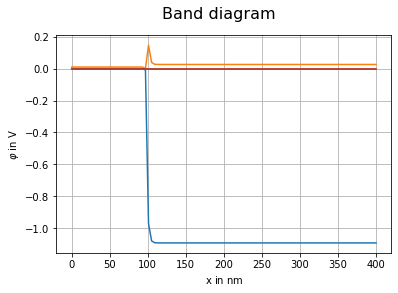

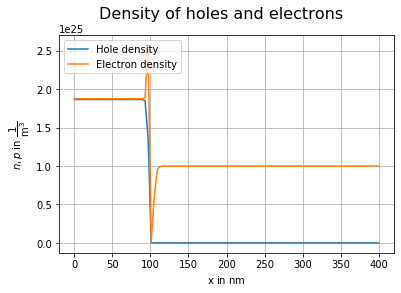

In [32]:
#
# Plot Band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[1::3]                                  , label='Quasi-Fermi-level of holes')
axis.plot(parameters.pos_x * 1E9, -parameters.u[2::3]                                  , label='Quasi-Fermi-level of electrons')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{V}$")

axis.grid()
plt.show()

#
# Plot hole and electron density
#
p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, p, label='Hole density')
axis.plot(parameters.pos_x * 1E9, n, label='Electron density')

#plt.ylim((0,.4E20))

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$n, p$ in $\mathrm{\dfrac{1}{m^3}}$")

axis.grid()
axis.legend(loc='upper left')
plt.show() 

## Perform gate voltage sweep

The seewp is performed between $U_{Start}=0$ and $U_{Stop}=4.0 \,\mathrm{V}$.
The voltage steps are small $\Delta U = 0.05\,\mathrm{V}$. <br>

In [33]:
solver.solve_from_doping()
solver.solve_no_bias()

voltage = []
current_density = []
jn_density = []
jp_density = []
charge = []


parameters.Cau = np.full(parameters.n, 0) #1E-24

#
#ramp up the voltage
#
u_actual = 0.0
u_stop    = .3
u_step    = 0.01

while (u_actual<=u_stop): #

    old_u = parameters.u.copy() # used 
    step_back = 0.0
    while (True):
        print("Voltage:", u_actual + u_step/2**step_back)
        if (solver.solve_bias(u_actual + u_step/2**step_back,0, norm_max=1E-2) == True): # 
            
            u_actual = u_actual + u_step/2**step_back
            break
            
        parameters.u = old_u.copy()
        step_back    = step_back + 1.0

    voltage.append(u_actual)
    current_density.append(np.mean(hole_current_density() + electron_current_density()))
    jn_density.append(np.mean(electron_current_density()))
    jp_density.append(np.mean(hole_current_density()))
    n = calc_n_density()
    charge.append(n.sum())

# Change order to get continuous data 
voltage.reverse()
current_density.reverse()
jn_density.reverse()
jp_density.reverse()
charge.reverse()

solver.solve_from_doping()
solver.solve_no_bias()

#
#ramp down the voltage
#
u_actual = 0.0
u_stop    = -.1
u_step    = -0.01


while (u_actual>=u_stop):

    old_u = parameters.u.copy() # used 
    step_back = 0.0
    while (True):
        print("Voltage:", u_actual + u_step/2**step_back)
        if (solver.solve_bias(u_actual + u_step/2**step_back,0, norm_max=1E-2) == True): # 
            
            u_actual = u_actual + u_step/2**step_back
            break
            
        parameters.u = old_u.copy()
        step_back    = step_back + 1.0
        
    voltage.append(u_actual)
    current_density.append(np.mean(hole_current_density() + electron_current_density()))
    jn_density.append(np.mean(electron_current_density()))
    jp_density.append(np.mean(hole_current_density()))
    n = calc_n_density()
    charge.append(n.sum())
  

Voltage: 0.01
Voltage: 0.02
Voltage: 0.03
Voltage: 0.04
Voltage: 0.05
Voltage: 0.060000000000000005
Voltage: 0.07
Voltage: 0.08
Voltage: 0.09
Voltage: 0.09999999999999999
Voltage: 0.10999999999999999
Voltage: 0.11999999999999998
Voltage: 0.12999999999999998
Voltage: 0.13999999999999999
Voltage: 0.15
Voltage: 0.16
Voltage: 0.17
Voltage: 0.18000000000000002
Voltage: 0.19000000000000003
Voltage: 0.20000000000000004
Voltage: 0.21000000000000005
Voltage: 0.22000000000000006
Voltage: 0.23000000000000007
Voltage: 0.24000000000000007
Voltage: 0.25000000000000006
Voltage: 0.26000000000000006
Voltage: 0.2700000000000001
Voltage: 0.2800000000000001
Voltage: 0.2900000000000001
Voltage: 0.3000000000000001
Voltage: -0.01
Voltage: -0.02
Voltage: -0.03
Voltage: -0.04
Voltage: -0.05
Voltage: -0.060000000000000005
Voltage: -0.07
Voltage: -0.08
Voltage: -0.09
Voltage: -0.09999999999999999
Voltage: -0.10999999999999999


## Plot the results

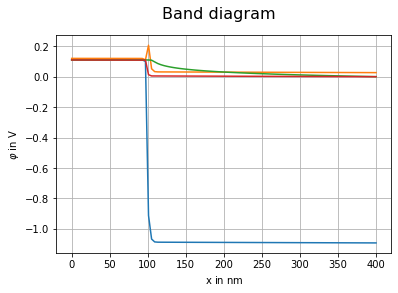

In [34]:
#
# Plot Band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram", fontsize=16)

axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi -  parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi                 , label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[1::3]                                  , label='Quasi-Fermi-level of holes')
axis.plot(parameters.pos_x * 1E9, -parameters.u[2::3]                                  , label='Quasi-Fermi-level of electrons')

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{V}$")

axis.grid()
plt.show()

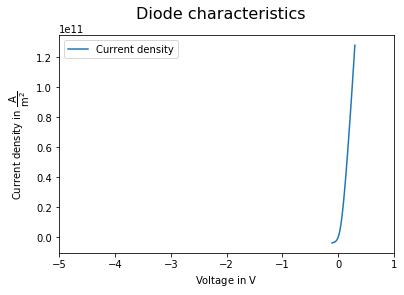

In [35]:
#
# Diode charactersistics
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(voltage, current_density, label='Current density')
#axis.plot(voltage, jn_density, label='Electron current density')
#axis.plot(voltage, jp_density, label='Hole current density')

axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")


axis.legend()
#plt.ylim(-6000, 1000)
plt.xlim(-5,1)

plt.show()


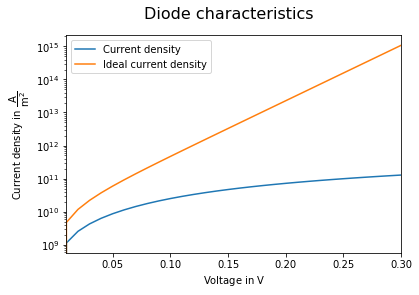

In [38]:
#
# Diode charactersistics
#

ideal_current_density = 1E10*(np.exp(np.array(voltage)/parameters.Ut)-1)
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(voltage, current_density, label='Current density')
axis.plot(voltage, ideal_current_density, label='Ideal current density')

axis.set_xlabel(r"Voltage in $\mathrm{V}$")
axis.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")


axis.legend()
#plt.ylim(1, 1E10)
axis.semilogy()
plt.xlim(.01,.3)

plt.show()